Importing all required libraries and functions first

In [1]:

!pip install bm3d
import os
import time
import bm3d
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage.metrics import structural_similarity

Defaulting to user installation because normal site-packages is not writeable


Defining functions for Artificial Noise-Adding Techniques
Gaussian Noise, as defined below

In [2]:
# def add_noise(image, sigma=1): #Gaussian noise
#     image = image + np.random.normal(0, sigma, image.shape)
#     return (image)
#     # return (add_blur(image, 3))

Defining functions for alternate Artificial Noise Technique
Salt 'n Pepper, as below 

In [3]:
def add_noise(image, sigma=0.1): #Salt-and-Pepper noise
    noisy = image.copy()
    noisy[np.random.rand(*image.shape) < sigma] = 0
    noisy[np.random.rand(*image.shape) < sigma] = 255
    return noisy
    # return (add_blur(noisy, 3))

Defining functions for Testing Methodology - PSNR and SSIM

In [4]:
def PSNR (original, processed):
    error = np.mean((original - processed)**2)
    if error == 0:
        return 100
    PIXEL_MAX = 255.0
    return (20*np.log10(PIXEL_MAX/np.sqrt(error)))

def SSIM (original, processed):
    return (structural_similarity (original, processed, multichannel=True))

Defining functions for Median Filter and conversion of images to grayscale

In [5]:
def grayscale(img):
	return np.dot(img[...,:3], [0.299, 0.587, 0.114])

def add_blur(image, kernel_size=3): 
    kernel = np.ones((kernel_size, kernel_size))/(kernel_size**2)
    blurred = convolve2d(image, kernel, mode='same')
    return (blurred)

def median_filter(data, kernel_size):
    temp = []
    indexer = kernel_size // 2
    data_final = []
    data_final = np.zeros((len(data),len(data[0])))
    for i in range(len(data)):
        for j in range(len(data[0])):
            for k in range(kernel_size):
                if i + k - indexer < 0 or i + k - indexer > len(data) - 1:
                    for c in range(kernel_size):
                        temp.append(0)
                else:
                    if j + k - indexer < 0 or j + indexer > len(data[0]) - 1:
                        temp.append(0)
                    else:
                        for x in range(kernel_size):
                            temp.append(data[i + k - indexer][j +  x - indexer])

            temp.sort()
            data_final[i][j] = temp[len(temp) // 2]
            temp = []
    return data_final

Creating arrays for Image Names/Locations, SSIM, PSNR lists and other processed values

In [6]:
images = ["dataset/pixel.jpg", "dataset/1to1.jpg", "dataset/fashion.jpg", "dataset/lena.jpg", "dataset/nature.jpg", "dataset/fractal.jpg", "dataset/painting.jpg", "dataset/food.jpg"]
image_list = []
noisy_image_list = []
denoised_image_bm3d = []
denoised_image_median = []
denoised_image_mixed = []

psnr_noisy_list = []
ssim_noisy_list = []

bm3d_times = []
bm3d_ssim = []
bm3d_psnr = []

median_times = []
median_ssim = []
median_psnr = []

mixed_times = []
mixed_ssim = []
mixed_psnr = []

Importing images, converting to grayscale and saving to arrays

In [7]:
for image in images:
    image = os.path.join(image) 
    image_list.append(grayscale(plt.imread(image)))

for image in image_list:
    noisy_image_list.append(add_noise(image, .05))

Processing images with Median Filter, BM3D and saving to arrays. 
Images are also being stored locally.

In [8]:
count = 1

for image in noisy_image_list:
    # Processing Median Filter
    start = time.time()
    denoised = median_filter(image, 3)
    end = time.time()
    denoised_image_median.append(denoised)
    img = os.path.join("processed_median/")
    img += str(count)
    img+= ".jpg"
    matplotlib.image.imsave(img, denoised, cmap='gray')
    median_times.append(end - start)

    denoised = 0
    
    # Processing BM3D
    start = time.time()
    denoised = bm3d.bm3d(image, sigma_psd=.05, stage_arg=bm3d.BM3DStages.ALL_STAGES)
    end = time.time()
    denoised_image_bm3d.append(denoised)
    img = os.path.join("processed_bm3d/")
    img += str(count)
    img+= ".jpg"
    matplotlib.image.imsave(img, denoised, cmap='gray')
    bm3d_times.append(end - start)

    denoised = 0

    # Processing Mixed
    start = time.time()
    denoised = median_filter(image, 3)
    denoised = add_blur(denoised, 2)
    end = time.time()
    denoised_image_mixed.append(denoised)
    img = os.path.join("processed_mixed/")
    img += str(count)
    img+= ".jpg"
    matplotlib.image.imsave(img, denoised, cmap='gray')
    mixed_times.append(end - start)

    count += 1    

In [9]:
# for i in range(len(images)):
#     print(image_list[i].shape)
#     print(noisy_image_list[i].shape)
#     print(denoised_image_bm3d[i].shape)
#     print(denoised_image_median[i].shape)
#     print(denoised_image_mixed[i].shape)
    

Processing PSNR, SSIM tests and saving values to arrays

In [10]:
for i in range(len(images)):
    psnr_noisy_list.append(PSNR(image_list[i], noisy_image_list[i]))
    ssim_noisy_list.append(SSIM(image_list[i], noisy_image_list[i]))
    bm3d_ssim.append(SSIM(image_list[i], denoised_image_bm3d[i]))
    bm3d_psnr.append(PSNR(image_list[i], denoised_image_bm3d[i]))
    median_ssim.append(SSIM(image_list[i], denoised_image_median[i]))
    median_psnr.append(PSNR(image_list[i], denoised_image_median[i]))
    mixed_ssim.append(SSIM(image_list[i], denoised_image_mixed[i]))
    mixed_psnr.append(PSNR(image_list[i], denoised_image_mixed[i]))

In [11]:
for i in range(len(images)):
    images[i] = images[i].replace("dataset/", "")
    images[i] = images[i].replace(".jpg", "")

for i in range (len(images)):
    print(images[i], i )

pixel 0
1to1 1
fashion 2
lena 3
nature 4
fractal 5
painting 6
food 7


Plotting PSNR Graphs for the two filters and in noisy state

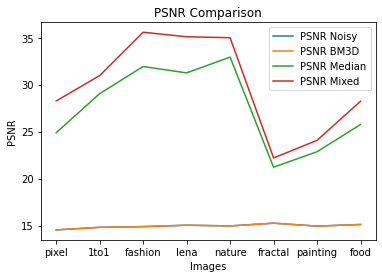

In [12]:
plt.plot(images, psnr_noisy_list, label="PSNR Noisy")
plt.plot(images, bm3d_psnr, label="PSNR BM3D")
plt.plot(images, median_psnr, label="PSNR Median")
plt.plot(images, mixed_psnr, label="PSNR Mixed")

plt.xlabel("Images")
plt.ylabel("PSNR")

plt.title("PSNR Comparison")
plt.legend()
plt.show()

Plotting SSIM Graphs for the two filters and in noisy state

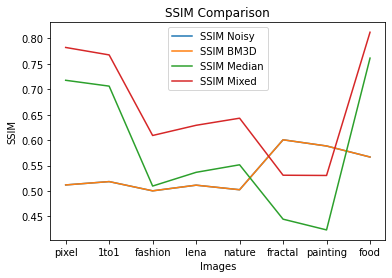

In [13]:
plt.plot(images, ssim_noisy_list, label="SSIM Noisy")
plt.plot(images, bm3d_ssim, label="SSIM BM3D")
plt.plot(images, median_ssim, label="SSIM Median")
plt.plot(images, mixed_ssim, label="SSIM Mixed")

plt.xlabel("Images")
plt.ylabel("SSIM")

plt.title("SSIM Comparison")
plt.legend()
plt.show()

Plotting Time Graphs for the two filters and in noisy state

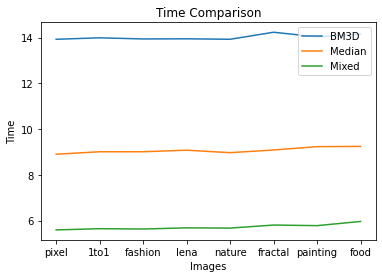

In [14]:
plt.plot(images, bm3d_times, label="BM3D")
plt.plot(images, median_times, label="Median")
plt.plot(images, mixed_times, label="Mixed")

plt.xlabel("Images")
plt.ylabel("Time")

plt.title("Time Comparison")
plt.legend()
plt.show()

% improvement of Median over BM3D

In [15]:
improvement_psnr = []
improvement_ssim = []
improvement_time = []

for i in range(len(images)):
    improvement_psnr.append((median_psnr[i] - bm3d_psnr[i])/bm3d_psnr[i]*100)
    improvement_ssim.append((median_ssim[i] - bm3d_ssim[i])/bm3d_ssim[i]*100)
    improvement_time.append((bm3d_times[i] - median_times[i])/median_times[i]*100)

print(improvement_psnr)
print(improvement_ssim)
print(improvement_time)

[71.11407934123537, 95.9873920372628, 114.4519630907011, 107.75483567599122, 120.04914811144849, 39.032761431516164, 52.96260091470126, 70.3725930655454]
[40.22638301912055, 36.22815742606229, 1.8818565765782918, 4.941993283982364, 9.767259332223878, -26.000637908768255, -28.060499749202965, 34.33516703020955]
[56.4754187106587, 55.304371745628345, 54.74640732340171, 53.654737459203304, 55.29370539081195, 56.67086706390868, 51.99856902067139, 53.11740212697495]
